In [1]:
import torch
from audiocraft.models.musicgen import MusicGen
from audiocraft.modules.conditioners import ChromaChordConditioner
from audiocraft.solvers.compression import CompressionSolver
import math
from pathlib import Path

/home/sake/.virtualenvs/MusicGen_Chord-VFGWlmB1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded = torch.load("/home/sake/checkpoint_5.th")

In [3]:
# from sys import getsizeof
# [x for x in loaded['model'].keys()]

In [4]:
# len([x for x in loaded['model'].values()])

In [5]:
# [x.shape for x in loaded['best_state']['model'].values()]

In [6]:
from audiocraft.models.builders import get_lm_model, get_compression_model, get_wrapped_compression_model
from omegaconf import OmegaConf

def _delete_param(cfg, full_name: str):
    parts = full_name.split('.')
    for part in parts[:-1]:
        if part in cfg:
            cfg = cfg[part]
        else:
            return
    OmegaConf.set_struct(cfg, False)
    if parts[-1] in cfg:
        del cfg[parts[-1]]
    OmegaConf.set_struct(cfg, True)

device = 'cuda'

In [7]:
# LM

cfg = OmegaConf.create(loaded['xp.cfg'])
cfg.device = str(device)
if cfg.device == 'cpu':
    cfg.dtype = 'float32'
else:
    cfg.dtype = 'float16'
_delete_param(cfg, 'conditioners.self_wav.chroma_chord.cache_path')
_delete_param(cfg, 'conditioners.self_wav.chroma_stem.cache_path')
_delete_param(cfg, 'conditioners.args.merge_text_conditions_p')
_delete_param(cfg, 'conditioners.args.drop_desc_p')

lm = get_lm_model(loaded['xp.cfg'])
lm.load_state_dict(loaded['fsdp_best_state']['model']) 
lm.eval()
lm.cfg = cfg

In [8]:
compression_model = CompressionSolver.wrapped_model_from_checkpoint(cfg, cfg.compression_model_checkpoint, device=device)

In [9]:
model = MusicGen("sakemin/musicgen-chord", compression_model, lm)

In [10]:
model.set_generation_params(duration=30)
model.lm = model.lm.to('cuda')

In [11]:
target_path = Path("/home/sake/chords_text_gen")

In [12]:
descriptions = ["disco style synth and beats, lady gaga, 2000s"]
chord_text = 'F G E:min A:min'
bpm = 110
in_triple = False

for i in range(len(descriptions)):
    if in_triple:
        descriptions[i] = descriptions[i] + ", in triple"
    descriptions[i] = descriptions[i] + f", bpm : {bpm}"

In [13]:
from audiocraft.data.audio import audio_write
import torchaudio
from tqdm import tqdm

In [14]:
chord_text.split(' ')

['F', 'G', 'E:min', 'A:min']

In [15]:
path = target_path/descriptions[0]/str(chord_text)
for i in tqdm(range(1)): 
    # print(descriptions)
    # wav = model.generate(descriptions)  # generates 3 samples.

    wav = model.generate_with_text_chroma(descriptions, chord_text, bpm = bpm, in_triple = in_triple)

    for idx, one_wav in enumerate(wav):
        # Will save under {idx}.wav, with loudness normalization at -14 db LUFS.
        path.mkdir(parents=True, exist_ok=True)
        audio_write(f'{str(path/str(i))}_{i}', one_wav.cpu(), model.sample_rate, strategy="loudness", loudness_compressor=True)

100%|██████████| 1/1 [00:38<00:00, 38.26s/it]


In [16]:
import pretty_midi as pm

In [17]:
import os
from audiocraft.modules.btc import mir_eval
from audiocraft.modules.btc.utils import logger
from audiocraft.modules.btc.btc_model import *
from audiocraft.modules.btc.utils.mir_eval_modules import audio_file_to_features, idx2chord, idx2voca_chord, get_audio_paths
import argparse
import warnings

warnings.filterwarnings('ignore')
logger.logging_verbosity(1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

config = HParams.load("/home/sake/musicgen/MusicGen_Chord/audiocraft/modules/btc/run_config.yaml")

config.feature['large_voca'] = True
config.model['num_chords'] = 170
model_file = '/home/sake/musicgen/MusicGen_Chord/audiocraft/modules/btc/test/btc_model_large_voca.pt'
idx_to_chord = idx2voca_chord()

btcmodel = BTC_model(config=config.model).to(device)

# Load model
if os.path.isfile(model_file):
    checkpoint = torch.load(model_file)
    mean = checkpoint['mean']
    std = checkpoint['std']
    btcmodel.load_state_dict(checkpoint['model'])
    logger.info("restore model")

# Audio files with format of wav and mp3
audio_paths = get_audio_paths(path)

# Chord recognition and save lab file
for i, audio_path in enumerate(audio_paths):
    logger.info("======== %d of %d in progress ========" % (i + 1, len(audio_paths)))
    # Load mp3
    feature, feature_per_second, song_length_second = audio_file_to_features(audio_path, config)
    logger.info("audio file loaded and feature computation success : %s" % audio_path)

    # Majmin type chord recognition
    feature = feature.T
    feature = (feature - mean) / std
    time_unit = feature_per_second
    n_timestep = config.model['timestep']

    num_pad = n_timestep - (feature.shape[0] % n_timestep)
    feature = np.pad(feature, ((0, num_pad), (0, 0)), mode="constant", constant_values=0)
    num_instance = feature.shape[0] // n_timestep

    start_time = 0.0
    lines = []
    with torch.no_grad():
        btcmodel.eval()
        feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
        for t in range(num_instance):
            self_attn_output, _ = btcmodel.self_attn_layers(feature[:, n_timestep * t:n_timestep * (t + 1), :])
            prediction, _ = btcmodel.output_layer(self_attn_output)
            prediction = prediction.squeeze()
            for i in range(n_timestep):
                if t == 0 and i == 0:
                    prev_chord = prediction[i].item()
                    continue
                if prediction[i].item() != prev_chord:
                    lines.append(
                        '%.3f %.3f %s\n' % (start_time, time_unit * (n_timestep * t + i), idx_to_chord[prev_chord]))
                    start_time = time_unit * (n_timestep * t + i)
                    prev_chord = prediction[i].item()
                if t == num_instance - 1 and i + num_pad == n_timestep:
                    if start_time != time_unit * (n_timestep * t + i):
                        lines.append('%.3f %.3f %s\n' % (start_time, time_unit * (n_timestep * t + i), idx_to_chord[prev_chord]))
                    break

    # lab file write
    if not os.path.exists(path):
        os.makedirs(path)
    save_path = os.path.join(path, os.path.split(audio_path)[-1].replace('.mp3', '').replace('.wav', '') + '.lab')
    with open(save_path, 'w') as f:
        for line in lines:
            f.write(line)

    logger.info("label file saved : %s" % save_path)

    # lab file to midi file
    

    starts, ends, pitchs = list(), list(), list()

    intervals, chords = mir_eval.io.load_labeled_intervals(save_path)
    for p in range(12):
        for i, (interval, chord) in enumerate(zip(intervals, chords)):
            root_num, relative_bitmap, _ = mir_eval.chord.encode(chord)
            tmp_label = mir_eval.chord.rotate_bitmap_to_root(relative_bitmap, root_num)[p]
            if i == 0:
                start_time = interval[0]
                label = tmp_label
                continue
            if tmp_label != label:
                if label == 1.0:
                    starts.append(start_time), ends.append(interval[0]), pitchs.append(p + 48)
                start_time = interval[0]
                label = tmp_label
            if i == (len(intervals) - 1): 
                if label == 1.0:
                    starts.append(start_time), ends.append(interval[1]), pitchs.append(p + 48)

    midi = pm.PrettyMIDI()
    instrument = pm.Instrument(program=0)

    for start, end, pitch in zip(starts, ends, pitchs):
        pm_note = pm.Note(velocity=120, pitch=pitch, start=start, end=end)
        instrument.notes.append(pm_note)

    midi.instruments.append(instrument)
    midi.write(save_path.replace('.lab', '.midi'))    



I MusicGen_Chord 09-25 08:32:20.370 333405880.py:29] restore model
I MusicGen_Chord 09-25 08:32:20.372 333405880.py:36] ======== 1 of 1 in progress ========


I MusicGen_Chord 09-25 08:32:22.323 333405880.py:39] audio file loaded and feature computation success : /home/sake/chords_text_gen/disco style synth and beats, lady gaga, 2000s, bpm : 110/F G E:min A:min/0_0.wav
I MusicGen_Chord 09-25 08:32:22.394 333405880.py:82] label file saved : /home/sake/chords_text_gen/disco style synth and beats, lady gaga, 2000s, bpm : 110/F G E:min A:min/0_0.lab


In [18]:
from audiocraft.modules.btc.utils.chords import Chords

In [19]:
chordreader = Chords()

In [20]:
crds = chordreader.load_chords(save_path)

In [21]:
crds

array([( 0.   ,  0.37 , (7, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       ( 0.37 ,  1.667, (3, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       ( 1.667,  2.963, (5, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       ( 2.963,  7.963, (0, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       ( 7.963, 10.278, (3, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (10.278, 12.315, (5, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (12.315, 14.63 , (3, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (14.63 , 16.852, (5, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (16.852, 19.074, (0, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (19.074, 21.296, (5, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (21.296, 23.611, (3, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (23.611, 26.574, (0, 0, [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], False)),
       (26.574, 27.778, (3, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,

In [22]:
timebin = 30/235
chroma = torch.zeros([235,12])

In [23]:
count = 0
for crd in crds:
    if count >= 235: 
        break
    if crd[2][0] == -1:
        multihot = torch.Tensor(crd[2][2])
    else:
        multihot = torch.concat([torch.Tensor(crd[2][2])[-crd[2][0]:],torch.Tensor(crd[2][2])[:-crd[2][0]]])
    start_bin = round(crd[0]/timebin)
    end_bin = round(crd[1]/timebin)
    for j in range(start_bin,end_bin):
        if count >= 235: 
            break
        chroma[j]=multihot
        count += 1

In [24]:
import matplotlib.pyplot as plt

In [25]:
chroma

tensor([[0., 0., 1.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [44]:
chroma_len = 235
n_chroma = 12

sample_rate = 32000
hop_size = 4096

bar2chromabin = sample_rate/hop_size
bpm_div = 3 if in_triple else 4

barsec = 60/(bpm/bpm_div)

timebin = barsec * bar2chromabin
rounded_timebin = round(timebin)

stext = chord_text.split(" ")

og_chroma = torch.zeros([chroma_len, n_chroma])
count = 0
offset = 0

while count < chroma_len:
    for tokens in stext:
        if count >= chroma_len: 
            break
        stoken = tokens.split(',')
        for token in stoken:
            off_timebin = timebin + offset
            rounded_timebin = round(off_timebin)
            offset = off_timebin - rounded_timebin
            offset = offset/len(stoken)
            add_step = rounded_timebin//len(stoken)
            mhot = chordreader.chord(token)
            rolled = np.roll(mhot[2], mhot[0])
            for i in range(count, count + add_step):
                if count >= chroma_len: 
                    break
                og_chroma[i] = torch.Tensor(rolled)
                count += 1
og_chroma[-15:], og_chroma.shape, count

(tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]]),
 torch.Size([235, 12]),
 235)

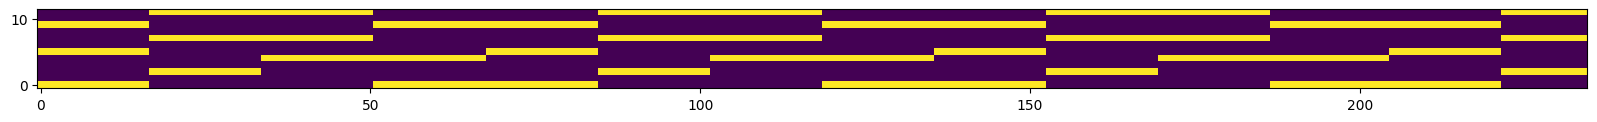

In [45]:
plt.figure(figsize = (20,2))
plt.imshow(og_chroma.T, origin='lower', interpolation='nearest')
# plt.savefig(save_path.replace('.lab', '.png'))

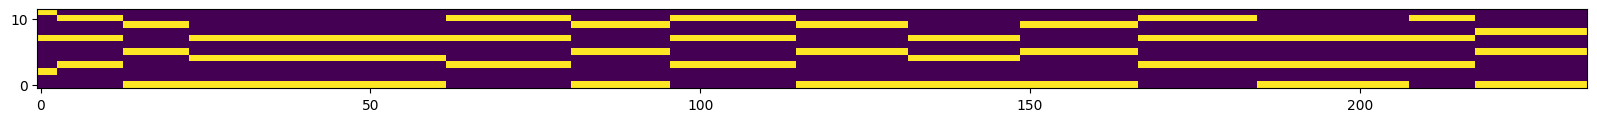

In [27]:
plt.figure(figsize = (20,2))
plt.imshow(chroma.T, origin='lower', interpolation='nearest')
plt.savefig(save_path.replace('.lab', '.png'))

In [26]:
import IPython.display as ipd
ipd.Audio(save_path.replace('.lab', '.wav'))

In [28]:
chord_text

'F G E:min A:min'

In [29]:
chords

['G',
 'D#',
 'F',
 'C',
 'D#',
 'F',
 'D#',
 'F',
 'C',
 'F',
 'D#',
 'C:min',
 'D#',
 'F:min']

In [ ]:
import numpy as np

In [ ]:
mhot = chordreader.chord("A:min")
mhot

In [ ]:
mhot.shape

In [ ]:
rolled = np.roll(mhot[2], mhot[0])

In [ ]:
loaded['xp.cfg']

In [ ]:
loaded['compression_model']

In [ ]:
model.lm.load_state_dict(loaded['best_state'])
model.lm.to('cuda')

In [ ]:
target_path = Path("/home/sake/chords_text_gen")

In [ ]:
loaded.keys()

In [ ]:
loaded['optimizer']

In [ ]:
loaded['fsdp_best_state']

In [ ]:
loaded['model']

In [ ]:
loaded['model']['condition_provider.conditioners.self_wav.output_proj.weight'].shape